<a href="https://colab.research.google.com/github/RysanDeluna/Quantum/blob/main/Grad_Research/ReadingResultsQiskit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Get packages

%%capture
%pip install qiskit qiskit_aer qiskit_ibm_runtime numpy pandas  matplotlib pylatexenc

from qiskit_ibm_runtime import QiskitRuntimeService

my_token = "d12fe2961e292ac5f42b07c822dcce9a5d26377ea5325cf1667af159e03bb7832f74c9553adb69f552c6efb87081953e33904466307610de060757263bebb077"
service = QiskitRuntimeService(channel="ibm_quantum", token=my_token)

# Aquisição e Tratamento dos dados

In [ ]:
def get_from_ibm(session_id: str):
  return service.jobs(limit=30, session_id=session_id)

In [ ]:
jobs = get_from_ibm('cw1cy9h54nq0008x6k9g')

In [ ]:
#@title Functions
# @markdown  Essa função pega todos os jobs de um determinado conjunto de experimentos e faz o download deles. `ideal` é um parâmetro booleano que controla o nome do arquivo.
# @markdown   ```python
# @markdown  calculate_bit_probabilities(counts)
# @markdown  show_results(result, name='')
# @markdown  show_results_sim(result, name='')
# @markdown   ```

import matplotlib.pyplot as plt
import numpy as np

def calculate_bit_probabilities(counts):
  num_bits = len(next(iter(counts)))  # Get the length of the bit strings
  bit_probabilities = [{'0': 0, '1': 0} for _ in range(num_bits)]
  total_counts = sum(counts.values())

  for bit_string, count in counts.items():
      for bit_pos, bit_value in enumerate(bit_string):
          bit_probabilities[bit_pos][bit_value] += count

  for bit_pos in range(num_bits):
      for bit_value in ['0', '1']:
          bit_probabilities[bit_pos][bit_value] /= total_counts

  return bit_probabilities

def show_result(result, name=''):  # result is a list of jobs
  # Sort the jobs based on the creation date so they follow the iteration path
  result.sort(key=lambda x: x.creation_date)

  probs = []
  for i in range(len(result)):
    probs.append(calculate_bit_probabilities(result[i].result()[0].data.cl.get_counts()))

  size = len(probs[0])  # Cells quantity

  # Defining the x and y axis
  x = np.arange(len(probs), dtype=int)  # Iterations
  y = np.arange(size, dtype=int)  # Cells
  Z = np.zeros((len(probs), size))  # Defining the dimensions
  for it in range(len(probs)):
    for cell in range(size):
      Z[it][cell] = probs[it][cell]['1']  # Probability of a cell be on state 1

  # Figure configuration
  plt.figure(figsize=(len(probs), size))
  extent = [0, len(probs), 0, size]
  plt.imshow(np.rot90(Z), extent=extent, aspect='equal', cmap='gist_yarg')
  plt.colorbar(label='Probability of being 1')
  plt.xlabel('Iteration')
  plt.ylabel('Cell')
  plt.xticks(ticks=np.arange(0, len(probs), 1))
  plt.grid(False)
  plt.title(f'Probability of Cell Being 1 at Each Iteration - {name}')
  plt.show()

def show_result_sim(result, name=''):  # result is a list of jobs
  probs = []
  for i in range(len(result)):
    probs.append(calculate_bit_probabilities(result[i].get_counts()))

  size = len(probs[0])  # Cells quantity

  # Defining the x and y axis
  x = np.arange(len(probs), dtype=int)  # Iterations
  y = np.arange(size, dtype=int)  # Cells
  Z = np.zeros((len(probs), size))  # Defining the dimensions
  for it in range(len(probs)):
    for cell in range(size):
      Z[it][cell] = probs[it][cell]['1']  # Probability of a cell be on state 1

  # Figure configuration
  plt.figure(figsize=(len(probs), size))
  extent = [0, len(probs), 0, size]
  plt.imshow(np.rot90(Z), extent=extent, aspect='equal', cmap='gist_yarg')
  plt.colorbar(label='Probability of being 1')
  plt.xlabel('Iteration')
  plt.ylabel('Cell')
  plt.xticks(ticks=np.arange(0, len(probs), 1))
  plt.grid(False)
  plt.title(f'Probability of Cell Being 1 at Each Iteration - {name}')
  plt.show()

def get_probs_from_results(results):
  probs = []
  for i in range(len(results)):
    probs.append([d['1'] for d in calculate_bit_probabilities(results[i].get_counts())])
  return probs

In [ ]:
# @title Leitura de experimentos
# @markdown   ```python
# @markdown   ler_resultados_ordenados(path)
# @markdown   ```
# @markdown   Lê arquivos de uma pasta zipada do drive


import json
import os
from qiskit_ibm_runtime import RuntimeDecoder
from google.colab import files
import zipfile
import re

ideal = '/content/drive/MyDrive/Colab Notebooks/TCC/experiments_results/ideal_experiments.zip'
noise = '/content/drive/MyDrive/Colab Notebooks/TCC/experiments_results/noise_experiments.zip'

def ler_resultados_ordenados(path):
  resultados = []
  with zipfile.ZipFile(path, 'r') as zip_ref:
    # Encontra todos os arquivos JSON dentro do ZIP
    nomes_arquivos = [nome for nome in zip_ref.namelist() if nome.endswith('.json')]

    # Ordena os arquivos pelo número no nome do arquivo
    nomes_arquivos.sort(key=lambda nome: int(re.search(r'_(\d+)_', nome).group(1)))

    # Lê os resultados de cada arquivo e adiciona à lista
    for nome_arquivo in nomes_arquivos:
      with zip_ref.open(nome_arquivo) as arquivo:
        dados = json.load(arquivo, cls=RuntimeDecoder)
        resultados.append(dados)  # Ou armazene o caminho: resultados.append(nome_arquivo)

  return resultados


In [ ]:
results_ideal = ler_resultados_ordenados(ideal)
results_noise = ler_resultados_ordenados(noise)

In [ ]:
# @title CA Clássico coisa de doido

binary_rule = lambda rule : np.array([int(bit) for bit in np.binary_repr(rule, 8)])
binary_rule(90)

rule_index = lambda l,m,r : 7 - (l*4 + m*2 + r*1)
rule_index(1,1,1)

def CA_step(config, rule):
  new_config = [0]*len(config)
  for i in range(0, len(config)):
    m = config[i]
    l = config[i-1] if i != 0 else config[-1]
    r = config[i+1] if i != len(config) - 1 else config[0]

    new_config[i] = rule[rule_index(l,m,r)]
  return new_config

def CA_run(initial_config, n_steps, rule_number):
  current_config = initial_config
  history = [list(current_config)]

  # Create rule
  rule = binary_rule(rule_number)

  # Run the CA
  for n in range(n_steps):
    current_config = CA_step(current_config, rule)
    history.append(current_config)

  return history

n_cells = 7
n_it = 3
data = np.zeros(n_cells, dtype=int)
data[int(n_cells/2)] = 1

import matplotlib.pyplot as plt

def print_automata_px(n_cells, n_it, data):
  px = 1/plt.rcParams['figure.dpi']

  fig, ax = plt.subplots(figsize=(n_it*px,n_cells*px))
  ax.matshow(data, cmap='gist_yarg')
  ax.axis(False)

def print_automata_std(data, x=10, y=5):
  fig, ax = plt.subplots(figsize=(x,y))
  ax.matshow(np.rot90(data), cmap='gist_yarg')

history = CA_run(data, n_steps=21, rule_number=90)
history

[[0, 0, 0, 1, 0, 0, 0],
 [0, 0, 1, 0, 1, 0, 0],
 [0, 1, 0, 0, 0, 1, 0],
 [1, 0, 1, 0, 1, 0, 1],
 [1, 0, 0, 0, 0, 0, 1],
 [1, 1, 0, 0, 0, 1, 1],
 [0, 1, 1, 0, 1, 1, 0],
 [1, 1, 1, 0, 1, 1, 1],
 [0, 0, 1, 0, 1, 0, 0],
 [0, 1, 0, 0, 0, 1, 0],
 [1, 0, 1, 0, 1, 0, 1],
 [1, 0, 0, 0, 0, 0, 1],
 [1, 1, 0, 0, 0, 1, 1],
 [0, 1, 1, 0, 1, 1, 0],
 [1, 1, 1, 0, 1, 1, 1],
 [0, 0, 1, 0, 1, 0, 0],
 [0, 1, 0, 0, 0, 1, 0],
 [1, 0, 1, 0, 1, 0, 1],
 [1, 0, 0, 0, 0, 0, 1],
 [1, 1, 0, 0, 0, 1, 1],
 [0, 1, 1, 0, 1, 1, 0],
 [1, 1, 1, 0, 1, 1, 1]]

#Histogramas

<ipython-input-8-25e7b675f7bd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['type'] = 'Ruidosa'
<ipython-input-8-25e7b675f7bd>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_i['type'] = 'Ideal'


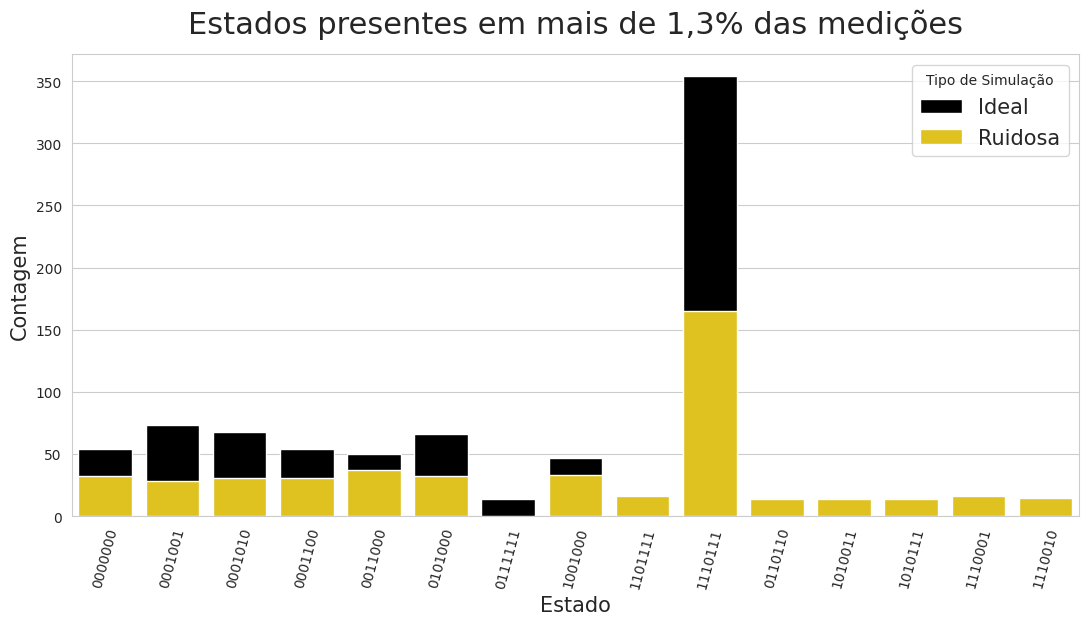

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

data = pd.DataFrame.from_dict(results_noise[21].get_counts(), orient='index', columns=['counts'])
data.sort_index(inplace=True)

data_i = pd.DataFrame.from_dict(results_ideal[21].get_counts(), orient='index', columns=['counts'])
data_i.sort_index(inplace=True)

filtered_data = data[data['counts'] > 0.013 * data['counts'].sum()]
filtered_i = data_i[data_i['counts'] > 0.013 * data_i['counts'].sum()]

# Combine the data into a single DataFrame
filtered_data['type'] = 'Ruidosa'
filtered_i['type'] = 'Ideal'
combined_data = pd.concat([filtered_i,filtered_data])

plt.figure(figsize=(13, 6))
# Create the barplot with hue for different colors
sns.barplot(x=combined_data.index, y='counts', hue='type', data=combined_data, dodge=False,
            palette={'Ruidosa': 'gold', 'Ideal': 'black'})

plt.xlabel('Estado', fontsize=15)
plt.xticks(rotation=75)
plt.ylabel('Contagem', fontsize=15)
plt.title('Estados presentes em mais de 1,3% das medições', fontsize=22, pad=15)
plt.legend(title='Tipo de Simulação', fontsize=15)  # Add a title to the legend
plt.savefig('./hist.pdf')
plt.show()

Embora a incerteza seja grande nessa iteração, como é possível ver pela quantidade de estados que foram encontrados em mais do que 1% das medições, o resultado esperado ainda é o que mais se sobressai dentre os demais.  

In [ ]:
states_noise = np.array([result.get_counts().most_frequent() for result in results_noise])
states_ideal = np.array([result.get_counts().most_frequent() for result in results_ideal])

In [ ]:
correct_noise = 0
correct_ideal = 0
for sn, si, t in zip(states_noise, states_ideal, history):
  bit_string = ''.join(str(b) for b in t)
  if sn == bit_string:
    correct_noise+=1
  if si == bit_string:
    correct_ideal+=1

print(correct_noise)
print(correct_ideal)

22
22


In [ ]:
states_noise[21]

'1110111'

In [ ]:
results_noise[21].get_counts().get(states_noise[21], 0) / 1024

0.1611328125

In [ ]:
results_ideal[21].get_counts().get(states_ideal[21], 0) / 1024

0.345703125

Todas as iterações tiveram como estado predominante o estado esperado, o que nos permite afirmar que a execução do autômato fora bem sucedida nos simuladores ao considerar que o estado mais predominante será o adotado como saída do circuito.

# Heatmaps

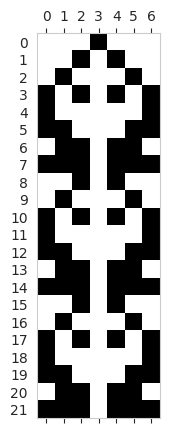

In [ ]:
def print_automata_std(data, x=10, y=5):
  fig, ax = plt.subplots(figsize=(x,y))
  ax.matshow(data, cmap='gist_yarg')
  plt.yticks(ticks=np.arange(0, len(data), 1))
  plt.grid(False)
print_automata_std(history)

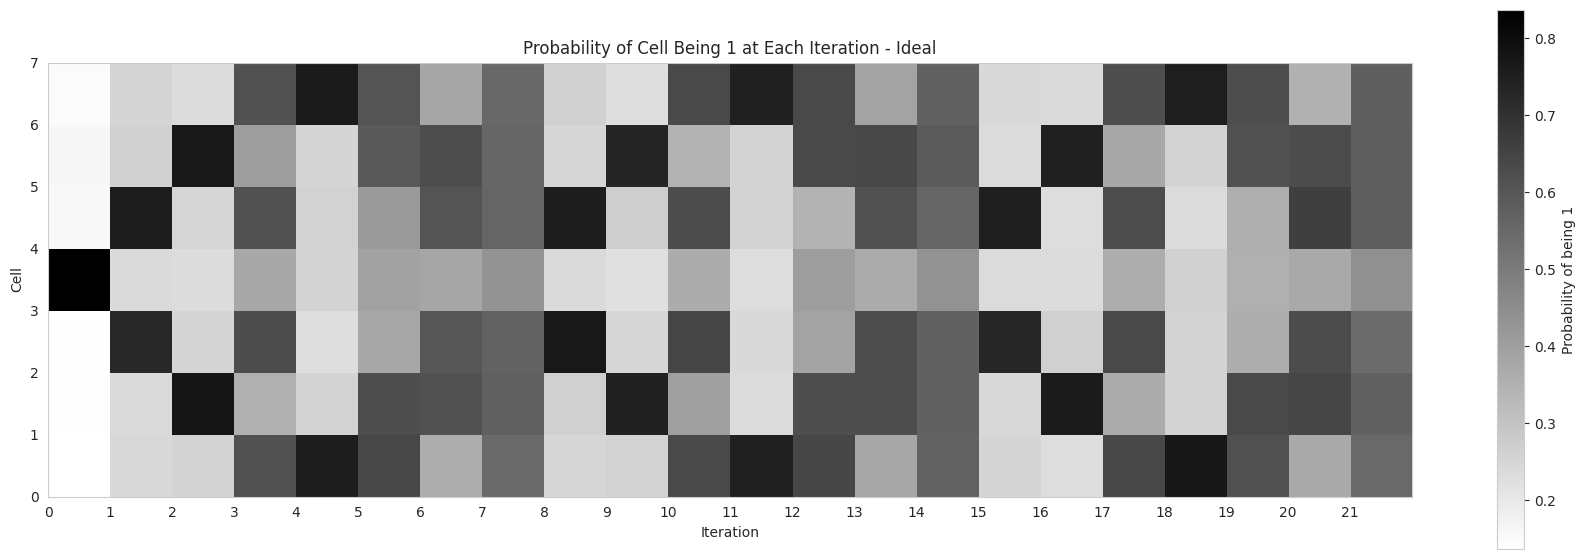

In [ ]:
show_result_sim(results_ideal, 'Ideal')

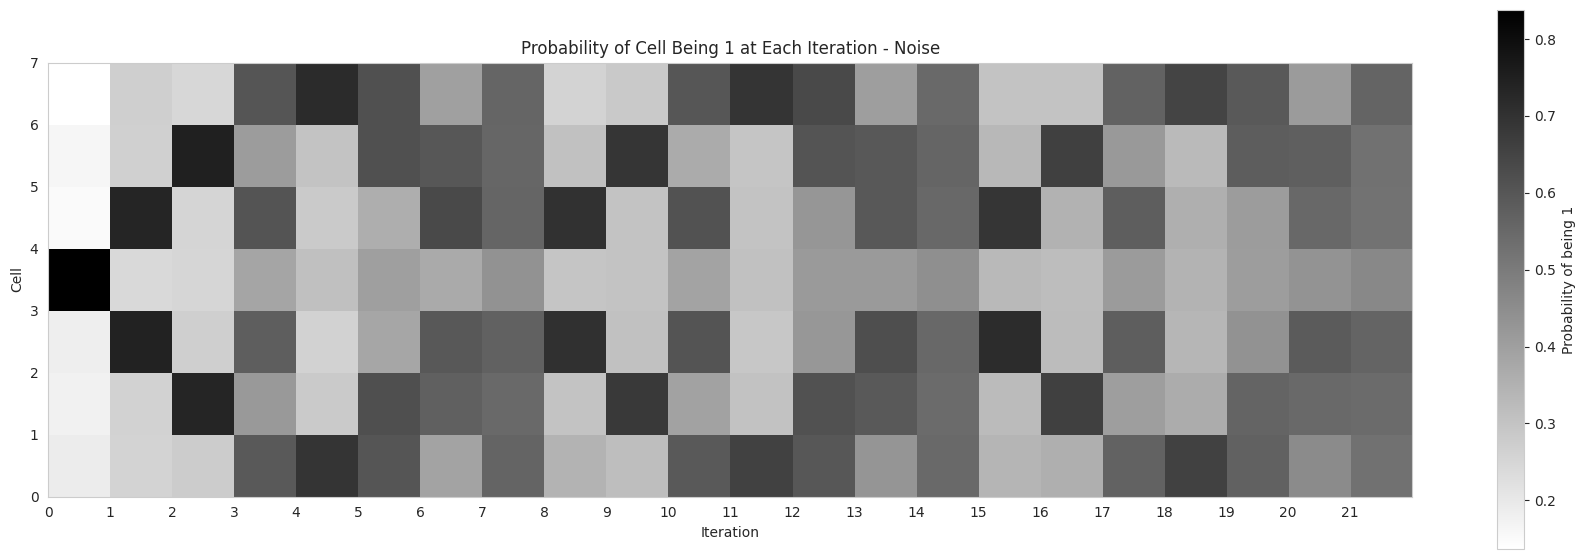

In [ ]:
show_result_sim(results_noise, 'Noise')

In [ ]:
probs_ideal = []
probs_noise = []

for i in range(len(history)):
  probs_ideal.append([d['1'] for d in calculate_bit_probabilities(results_ideal[i].get_counts())])
  probs_noise.append([d['1'] for d in calculate_bit_probabilities(results_noise[i].get_counts())])

true  = np.array(history)
probs_ideal = np.array(probs_ideal)
diff_ideal = true - probs_ideal

probs_noise = np.array(probs_noise)
diff_noise = true - probs_ideal

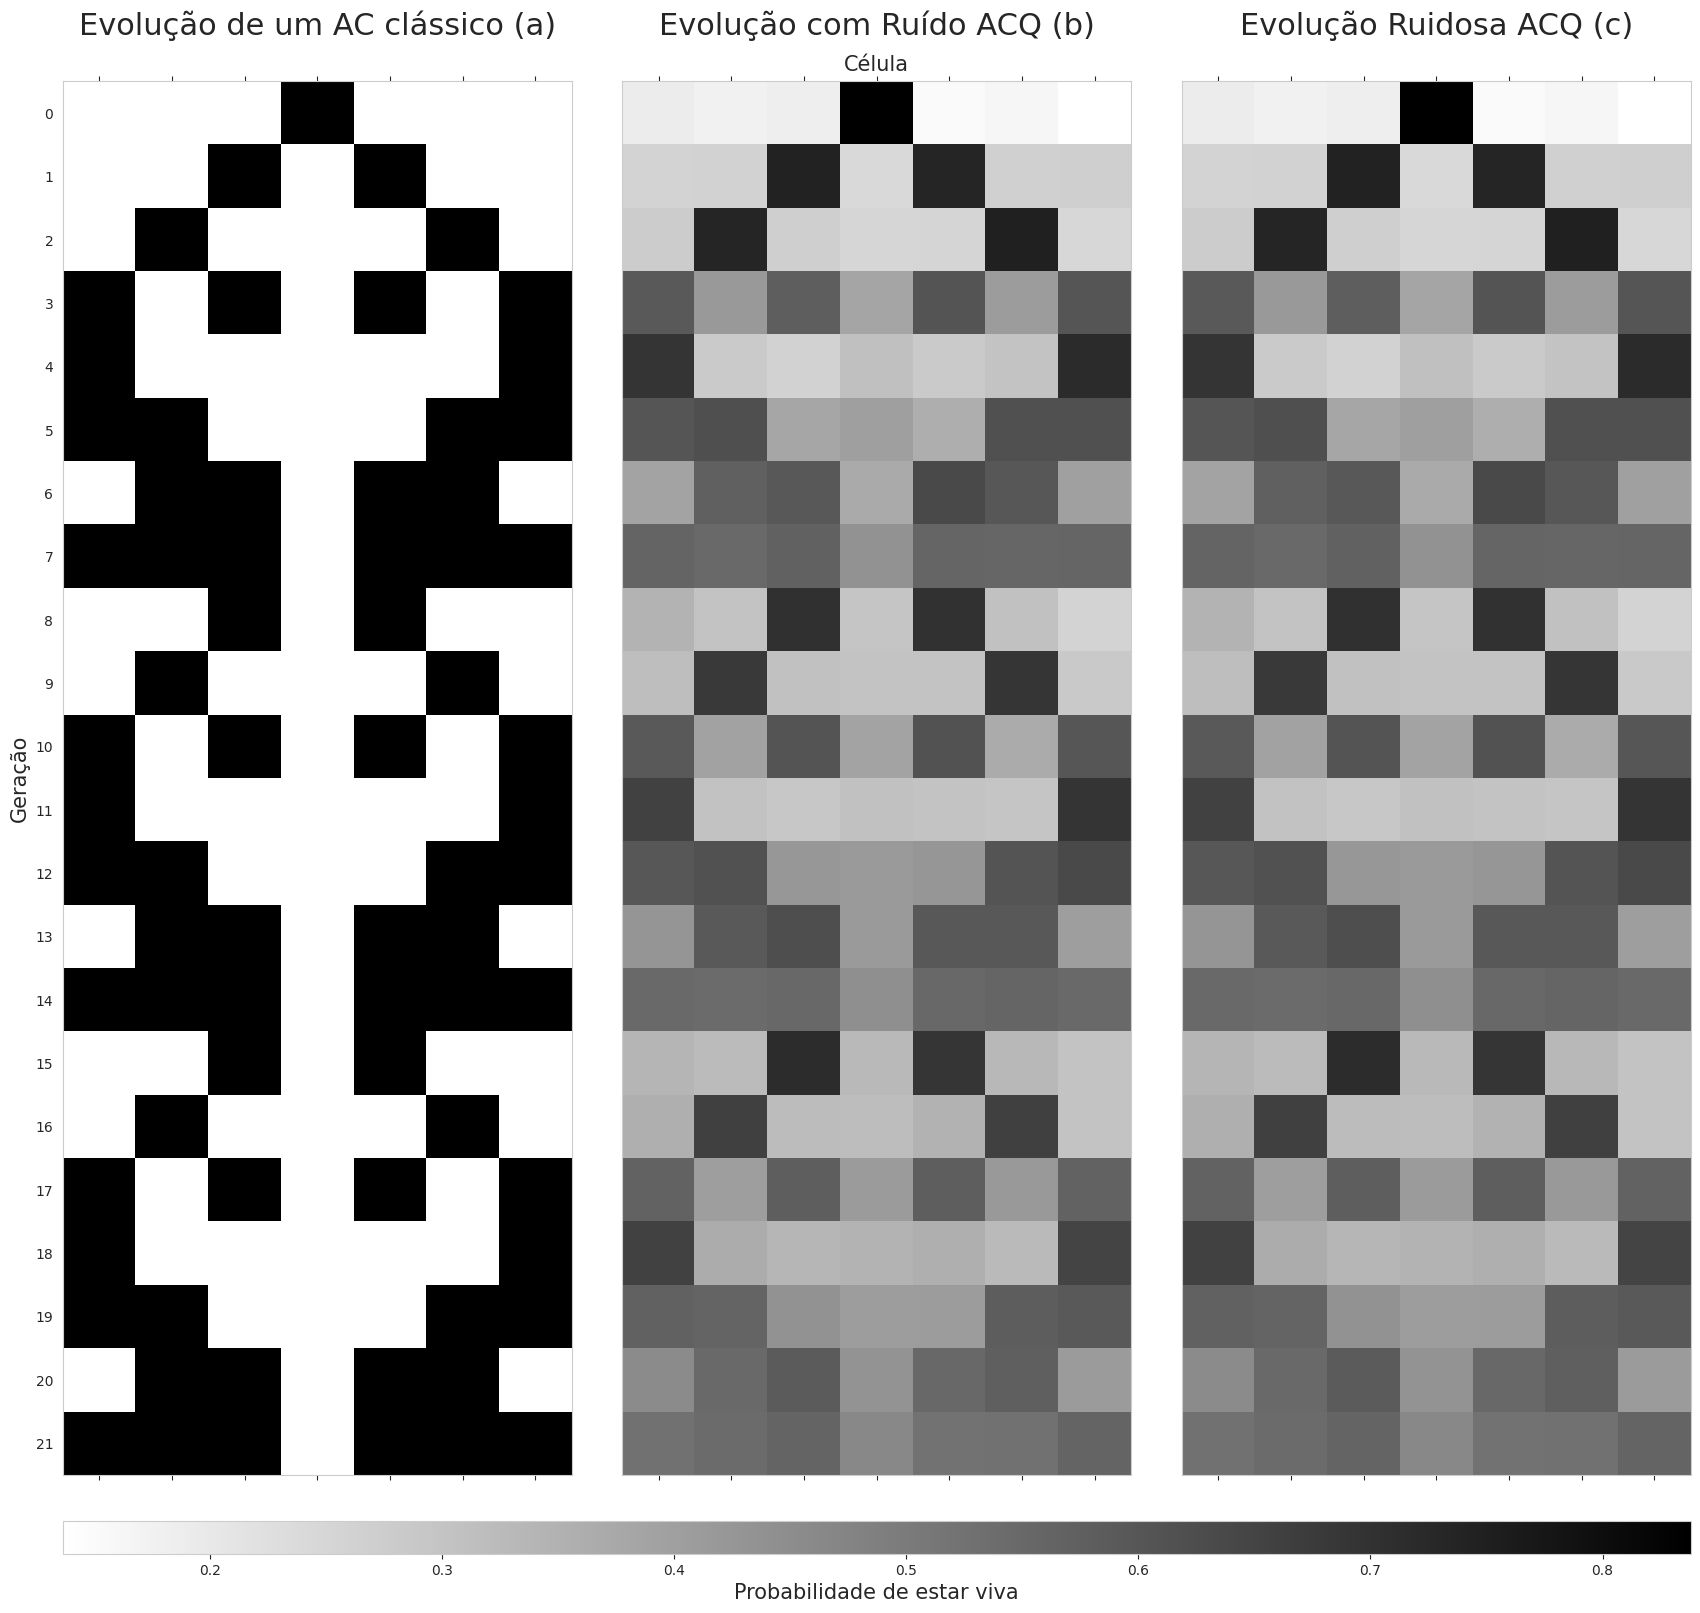

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(len(diff_noise[0])*3, len(diff_ideal)),
                         sharex=True, sharey=True, gridspec_kw={'height_ratios': [19, 2]})

axes[0][0].matshow(history, cmap='gist_gray_r', aspect='auto')
axes[0][0].set_title('Evolução de um AC clássico (a)', fontsize=22, pad=15)
axes[0][0].set_ylabel('Geração', fontsize=15)
axes[0][0].sharey(axes[0][0])

im_ideal = axes[0][1].matshow(get_probs_from_results(results_noise), cmap='gist_gray_r', aspect='auto')
axes[0][1].set_title('Evolução com Ruído ACQ (b)', fontsize=22, pad=15)
#axes[0][1].set_xlabel('Geração', fontsize=15)

im_noise = axes[0][2].matshow(get_probs_from_results(results_noise), cmap='gist_gray_r', aspect='auto')
axes[0][2].set_title('Evolução Ruidosa ACQ (c)', fontsize=22, pad=15)
axes[0][2].sharex(axes[0][0])

# cb = fig.colorbar(im_ideal, ax=axes[:], use_gridspec=True,
#              pad=0.02, aspect=50)  # Colorbar for both
cb = fig.colorbar(im_ideal, ax=axes[:], use_gridspec=True,
            aspect=50, orientation='horizontal')  # Colorbar for both
cb.set_label(label='Probabilidade de estar viva', fontsize=15)
fig.align_xlabels(axes[:][1])

plt.yticks(ticks=np.arange(0, len(history), 1))
# axes[0][1].yaxis.set_ticks_position('left')
# axes[0][2].yaxis.set_ticks_position('left')

axes[0][0].set_xlabel(' ', fontsize=15)
axes[0][1].set_xlabel('Célula', fontsize=15)
axes[0][2].set_xlabel(' ', fontsize=15)


axes[0][0].xaxis.set_label_position('top')
axes[0][1].xaxis.set_label_position('top')
axes[0][2].xaxis.set_label_position('top')

axes[1][0].set_visible(False)
axes[1][1].set_visible(False)
axes[1][2].set_visible(False)

fig.subplots_adjust(wspace=0.1)


for a in axes:
  for ax in a:
    ax.grid(False)

plt.savefig('ECN.pdf')
plt.show()

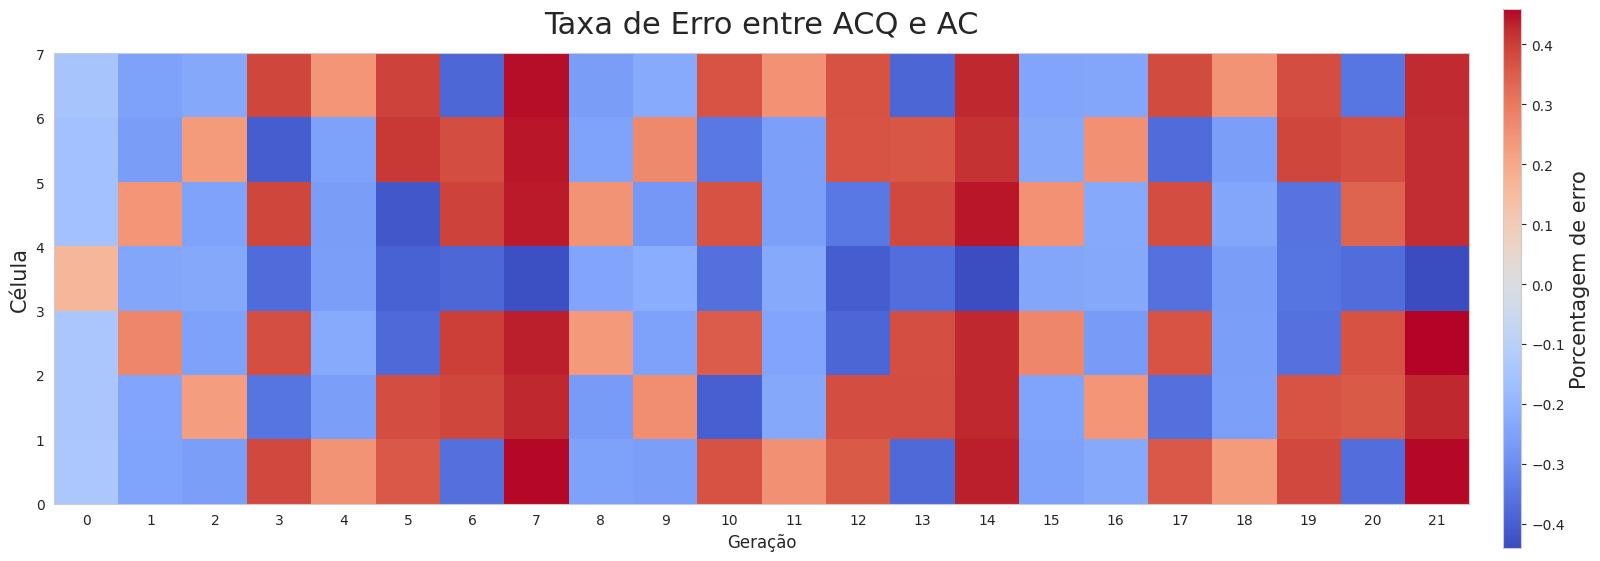

In [ ]:
size = len(diff_noise[0])

plt.figure(figsize=(len(diff_noise), size))
extent = [0, len(probs_noise), 0, size]
plt.imshow(np.rot90(diff_noise), extent=extent, aspect='equal', cmap='coolwarm')
cb = plt.colorbar(pad=0.02, aspect=30)
cb.set_label(label='Porcentagem de erro', fontsize=15)
plt.xlabel('Geração', fontsize=12)
plt.xticks(ticks=np.arange(0.5, len(diff_noise), 1), labels=np.arange(0, len(diff_noise), 1))
plt.ylabel('Célula', fontsize=15)
plt.grid(False)
plt.title(f'Taxa de Erro entre ACQ e AC', pad=15, fontsize=22)
plt.savefig('./ECN_error.pdf')
plt.show()

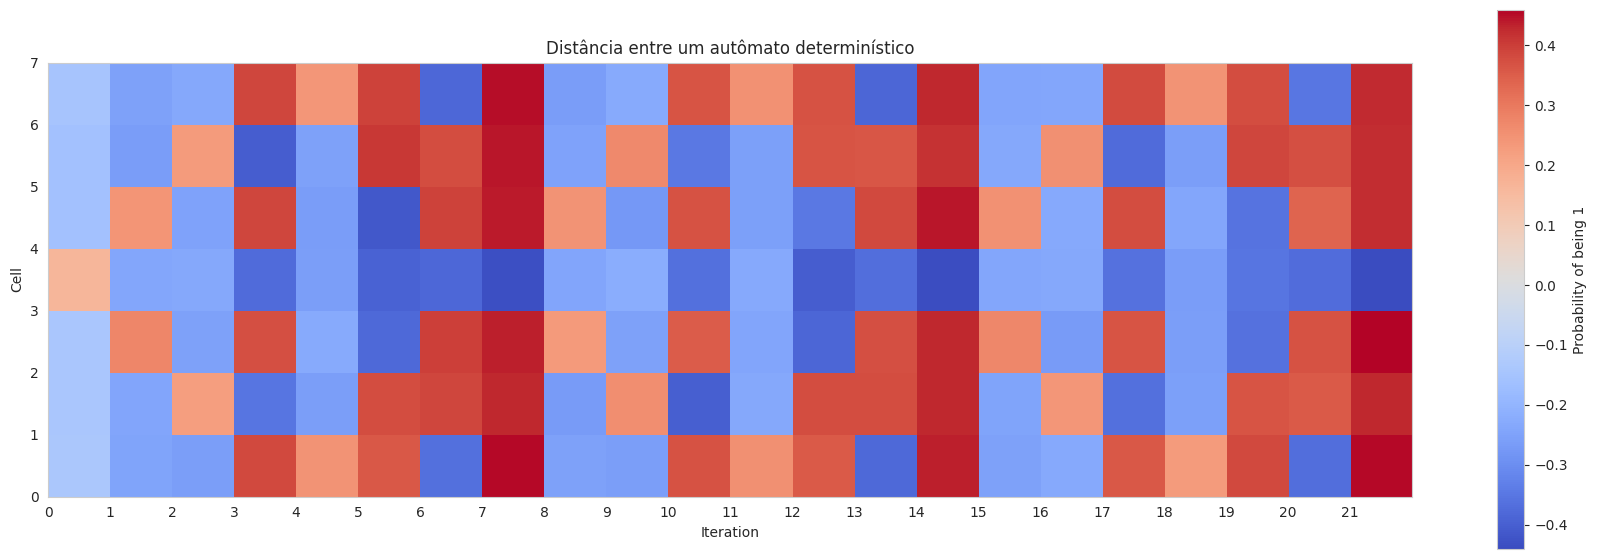

In [ ]:
size = len(diff_ideal[0])

plt.figure(figsize=(len(diff_ideal), size))
extent = [0, len(probs_ideal), 0, size]
plt.imshow(np.rot90(diff_ideal), extent=extent, aspect='equal', cmap='coolwarm')
plt.colorbar(label='Probability of being 1')
plt.xlabel('Iteration')
plt.xticks(ticks=np.arange(0, len(diff_ideal), 1))
plt.ylabel('Cell')
plt.grid(False)
plt.title(f'Distância entre um autômato determinístico')
plt.show()